In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from project_resources.import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import *

importing Jupyter notebook from C:\Users\Lukas\Documents\datacytochromy\project_resources\cytochrome_P450.ipynb


In [2]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
isozymes = ["3A4", "RLM", "HLC"]
rel_paths = {
    "3A4_source": r"project_resources/ChEMBL_3A4.csv",
    "3A4_sep": ";",
    "3A4": r"project_resources/3A4.csv",
    "3A4_jazzy_mol_fts": r"project_resources/jazzy/3A4_jazzy_mol_fts.csv",
    "3A4_mol_indexes": r"project_resources/molecule_indexes/3A4_mol_indexes.json",

    "RLM_source": r"project_resources/AID_1508591_datatable_all.csv",
    "RLM_sep": ",",
    "RLM": r"project_resources/RLM.csv",
    "RLM_jazzy_mol_fts": r"project_resources/jazzy/RLM_jazzy_mol_fts.csv",
    "RLM_mol_indexes": r"project_resources/molecule_indexes/RLM_mol_indexes.json",

    "HLC_source": r"project_resources/AID_1508603_datatable_all.csv",
    "HLC_sep": ",",
    "HLC": r"project_resources/HLC.csv",
    "HLC_jazzy_mol_fts": r"project_resources/jazzy/HLC_jazzy_mol_fts.csv",
    "HLC_mol_indexes": r"project_resources/molecule_indexes/HLC_mol_indexes.json"
}
smiles = {}
mol_features = {}
mol_halflife_vals = {}
mol_fts_arrays = {}
xy_splits = {}
tanimoto_sims = {}
y_test_avg_predictions = {}
stds = {}
rmsds = {}
best_models = {}
# lists of repeatedly needed and\or similar info
# dicts for storing outputs and potentially writing them into a file

In [3]:
for isozyme in isozymes:
    csv_data_formatting(rel_paths[f"{isozyme}_source"], isozyme, sep=rel_paths[f"{isozyme}_sep"])
    df = pd.read_csv(rel_paths[isozyme])
    smiles[isozyme] = df["smiles"]
    print(f"{isozyme, list(smiles[isozyme][:10])}\n")

3A4.csv already exists in dir
('3A4', ['COc1ccc2[nH]cc(CCNC(C)=O)c2c1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3nnc(Cc4ccc(F)cc4F)cc32)[C@@H](CN2Cc3c(F)cccc3C2=O)CN1', 'O=c1[nH]c2ccccc2n1C1CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc([C@@H](O)c4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2Cc3ccccc3C2=O)CN1', 'CCC(=O)NCC[C@@H]1CCc2ccc3c(c21)CCO3', 'C[C@@H]1CN(CC(=O)N2CC(C)(C)c3ncc(Cc4ccc(F)cc4)cc32)[C@@H](CN2[C@H](C)COC[C@H]2C)CN1', 'COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', 'CC(C)O[P@@]1(=O)OC[C@H]2O[C@@H](n3ccc(=O)[nH]c3=O)[C@@]3(CCO3)[C@@H]2O1', 'CCS(=O)(=O)c1ccc2oc(-c3ccc4ccccc4c3)nc2c1'])

RLM.csv already exists in dir
('RLM', ['CCCCOC1=CC=C(C=C1)CC(=O)NO', 'COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC', 'COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3=CC=CO3', 'CC(C)(C)N1C2=NC=NC(=C2C(=N1)C3=CC=C(C=C3)Cl)N', 'CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4)C5CCCCC5', 'CC1=C(C=C(C=C1)NS(=O)(=O)

In [4]:
for isozyme in isozymes:
    print(isozyme)
    try:
        mol_fts_df = pd.read_csv(rel_paths[f"{isozyme}_jazzy_mol_fts"])

        features = list(mol_fts_df.columns)
        features.remove("smiles")
        print(features)
        # list of all features present in csv file

        isozyme_fts = []
        for i in range(len(mol_fts_df["smiles"])):
            smiles_fts = {}
            for feature in features:
                smiles_fts[feature] = mol_fts_df[feature][i]
            isozyme_fts.append(smiles_fts)
        mol_features[isozyme] = isozyme_fts
        # extract the molecule features from csv file and save them to a variable

        nan_values_indexes = []
        mol_fts = mol_features[isozyme]
        for mol, index in zip(mol_fts, range(1, len(mol_fts))):
            contains_nan = np.isnan(list(mol.values())).any()
            if contains_nan:
                nan_values_indexes.append(index)
        print(nan_values_indexes)
        # get the indexes of molecules which don't have a value for any feature

        halflife_df = pd.read_csv(rel_paths[isozyme])
        for nan_index in nan_values_indexes:
            halflife_df = halflife_df.drop(nan_index)
        print(len(halflife_df["smiles"]))
        mol_halflife_vals[isozyme] = halflife_df["half-life"]
        print(len(mol_halflife_vals[isozyme]), mol_halflife_vals[isozyme][:4])
        # remove each molecule with missing feature values from half-life set
        # this ensures that both x and y sets for ML have the same shape
        # and also that each molecule always gets paired with the correct set of features

        mol_fts_df = mol_fts_df.dropna(ignore_index=True)
        #mol_fts_df = mol_fts_df.dropna()
        isozyme_fts = []
        for i in range(len(mol_fts_df["smiles"])):
            smiles_fts = {}
            for feature in features:
                smiles_fts[feature] = mol_fts_df[feature][i]
            isozyme_fts.append(smiles_fts)
        mol_features[isozyme] = isozyme_fts
        # drop all rows which contain NaN values, by deafault axis labels range from 1 ... n
        # ignore_index=True => axis lables range from 0 ... n-1

        print(len(mol_features[isozyme]), mol_features[isozyme][0:2])

    except FileNotFoundError:
        df = pd.read_csv(rel_paths[isozyme])
        smiles = df["smiles"]
        # load smiles for isozyme
        mol_features[isozyme] = mol_fts(smiles, isozyme)
        # calculate molecule features for list of smiles
        mol_fts_df = pd.DataFrame()
        mol_fts_df["smiles"] = smiles
        # create new df with the first column being smiles from the given isozyme
        features = [feature for feature in mol_features[isozyme][0]]
        # list of possible molecule features

        for feature in features:
            single_feature_list = []
            for i in range(len(mol_features[isozyme])):
                if mol_features[isozyme][i] == mol_features[isozyme][i]:
                    single_feature_list.append(mol_features[isozyme][i][feature])
                else:
                    single_feature_list.append(np.nan)
            mol_fts_df[feature] = single_feature_list
        # write the value of a given feature for each molecule into df

        mol_fts_df.to_csv(abs_file_path(rel_paths[f"{isozyme}_jazzy_mol_fts"]), index=False)
        # create final csv

3A4
['sdc', 'sdx', 'sa', 'dga', 'dgp', 'dgtot']
[]
70
70 0    0.3333
1    1.1670
2    0.0450
3    0.4667
Name: half-life, dtype: float64
70 [{'sdc': 6.9114, 'sdx': 1.1972, 'sa': 3.4065, 'dga': -5.028, 'dgp': -67.7113, 'dgtot': -72.7393}, {'sdc': 16.8081, 'sdx': 0.608, 'sa': 7.5495, 'dga': -10.882, 'dgp': -153.8596, 'dgtot': -135.4269}]
RLM
['sdc', 'sdx', 'sa', 'dga', 'dgp', 'dgtot']
[32, 1998, 2044, 2079, 2116, 2196, 2214]
2524
2524 0    30.0
1    30.0
2    30.0
3    30.0
Name: half-life, dtype: float64
2524 [{'sdc': 5.9606, 'sdx': 1.7203, 'sa': 2.9233, 'dga': 2.3403, 'dgp': -62.5586, 'dgtot': -60.2183}, {'sdc': 7.2935, 'sdx': 2.1751, 'sa': 4.7052, 'dga': -5.366, 'dgp': -92.3442, 'dgtot': -92.2883}]
HLC
['sdc', 'sdx', 'sa', 'dga', 'dgp', 'dgtot']
[]
189
189 0     8.2
1     8.6
2     9.6
3    17.3
Name: half-life, dtype: float64
189 [{'sdc': 8.1842, 'sdx': 0.767, 'sa': 3.7903, 'dga': -16.3222, 'dgp': -76.5154, 'dgtot': -85.8172}, {'sdc': 7.8084, 'sdx': 0.0, 'sa': 2.1929, 'dga': -6.1343,

In [5]:
# end of error raised when a NaN value is present:
    # ValueError: Input X contains NaN.ElasticNet does not accept missing values encoded as NaN natively.
    # For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and
    # Regressor which accept missing values encoded as NaNs natively.
    # Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline
    # or drop samples with missing values.
    # See https://scikit-learn.org/stable/modules/impute.html
    # You can find a list of all estimators that handle NaN values at the following page:
    # https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# solution: remove all molecules with NaN as a value for any feature and their corresponding halflife value...

In [6]:
for isozyme in isozymes:
    arrays_list = [np.array(list(d.values())) for d in mol_features[isozyme]]
    mol_fts_arrays[isozyme] = arrays_list
    print(mol_fts_arrays[isozyme][0:2])

[array([  6.9114,   1.1972,   3.4065,  -5.028 , -67.7113, -72.7393]), array([  16.8081,    0.608 ,    7.5495,  -10.882 , -153.8596, -135.4269])]
[array([  5.9606,   1.7203,   2.9233,   2.3403, -62.5586, -60.2183]), array([  7.2935,   2.1751,   4.7052,  -5.366 , -92.3442, -92.2883])]
[array([  8.1842,   0.767 ,   3.7903, -16.3222, -76.5154, -85.8172]), array([  7.8084,   0.    ,   2.1929,  -6.1343, -49.0782, -55.2125])]


In [8]:
# train-test split
for isozyme in isozymes:
    # molecule features as numpy arrays of smiles from given isozyme
    x = np.array(mol_fts_arrays[isozyme])
    # halflife values corresponding to each of the fps
    y = np.log(np.array(mol_halflife_vals[isozyme]))
    
    idx_train, idx_test = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

    x_train = x[idx_train]
    x_test = x[idx_test]

    y_train = y[idx_train]
    y_test = y[idx_test]

    fps_train = np.array(mol_fts_arrays[isozyme])[idx_train]
    fps_test = np.array(mol_fts_arrays[isozyme])[idx_test]

    xy_splits[isozyme] = [x_train, x_test, y_train, y_test]

    print(x.shape, y.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape, fps_train.shape, fps_test.shape)

(70, 6) (70,) (56, 6) (14, 6) (56,) (14,) (56, 6) (14, 6)
(2524, 6) (2524,) (2019, 6) (505, 6) (2019,) (505,) (2019, 6) (505, 6)
(189, 6) (189,) (151, 6) (38, 6) (151,) (38,) (151, 6) (38, 6)


In [ ]:
for isozyme in isozymes:
    x_train = xy_splits[isozyme][0]
    x_test = xy_splits[isozyme][1]
    y_train = xy_splits[isozyme][2]
    y_test = xy_splits[isozyme][3]
    print(isozyme)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    y_test_avg_predict, std, rmsd = mol_predict_and_std(models, x_train, x_test, y_train, y_test)
    y_test_avg_predictions[isozyme] = y_test_avg_predict
    stds[isozyme] = std
    rmsds[isozyme] = rmsd
    print(f"     root-mean-square deviations: {rmsds[isozyme]}\n")

3A4
(56, 6) (56,) (14, 6) (14,)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0.1)
     best linear hyperparams: ElasticNet(alpha=0.0001, l1_ratio=0)
     best linear hyperparams: ElasticNet(alpha=1e-05, l1_ratio=0)
     best KRR hyperparams: KernelRidge(alpha=0.04281332398719392, gamma=3.792690190732238e-05,
            kernel='rbf')
     best KRR hyperparams: KernelRidge(alpha=0.00206913808111479, gamma=2.3357214690901212e-07)
     best KRR hyperparams: KernelRidge(alpha=0.14384498882876628, gamma=3.792690190732238e-05,
            kernel='rbf')
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=1, n_estimators=20)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=1, n_estimators=400)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, max_depth=2, n_estimators=10)
     best RF hyperparams: RandomForestRegressor(max_features='log2', n_estimators=20)
     best RF hyperparams: RandomFores

In [129]:
for isozyme in isozymes:
    isozyme_rmsd = list(rmsds[isozyme].values())
    lowest_rmsd = min(isozyme_rmsd)
    best_model_for_isozyme = list(rmsds[isozyme].keys())[list(rmsds[isozyme].values()).index(lowest_rmsd)]
    best_models[isozyme] = best_model_for_isozyme
    print(f"best model for {isozyme}: {best_model_for_isozyme} with rmsd {lowest_rmsd}")

best model for 3A4: GB with rmsd 1.3171795501859043
best model for RLM: RF with rmsd 0.8937459777836787
best model for HLC: GB with rmsd 0.4944413011304564


In [153]:
for isozyme in isozymes:
    tanimoto_similarities = tanimoto(xy_splits[isozyme][1], xy_splits[isozyme][0])
    tanimoto_sims[isozyme] = tanimoto_similarities

ValueError: BitVects must be same length

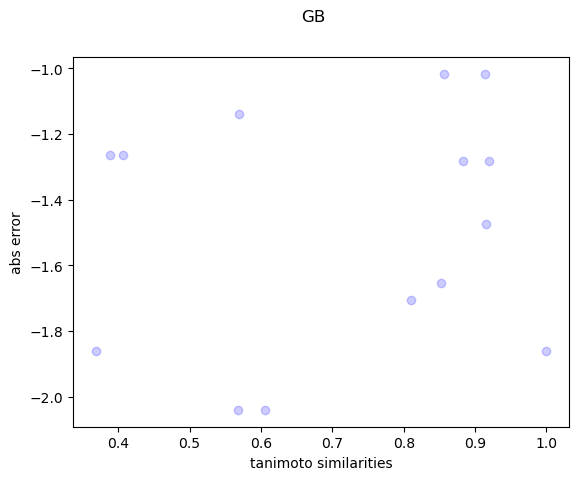

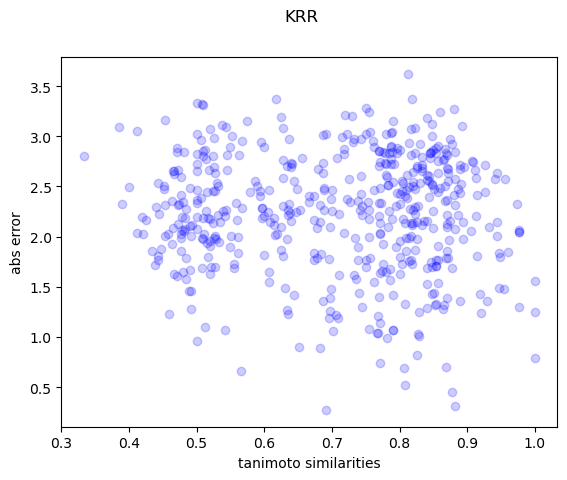

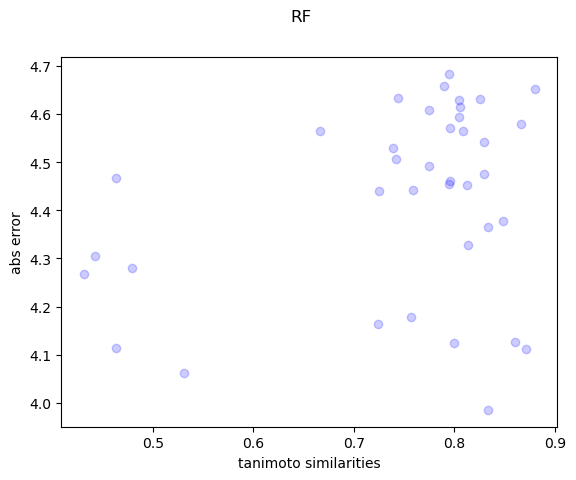

In [34]:
for isozyme in isozymes:
    model = best_models[isozyme]
    create_scatter_plot(tanimoto_sims[isozyme], y_test_avg_predictions[isozyme][model], model, "tanimoto similarities", "abs error")

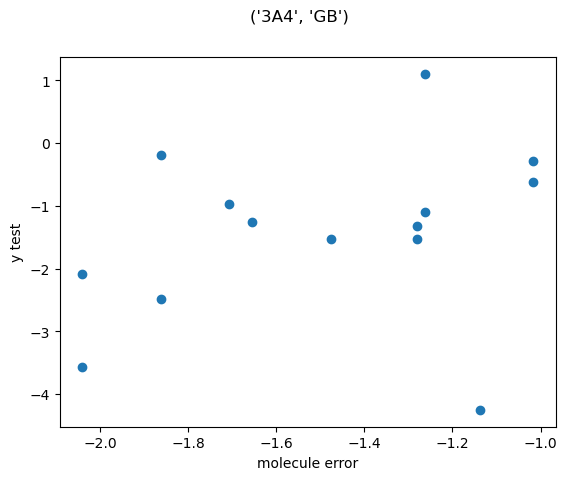

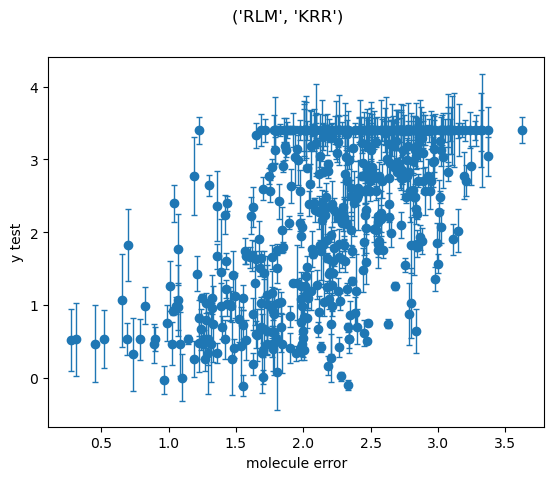

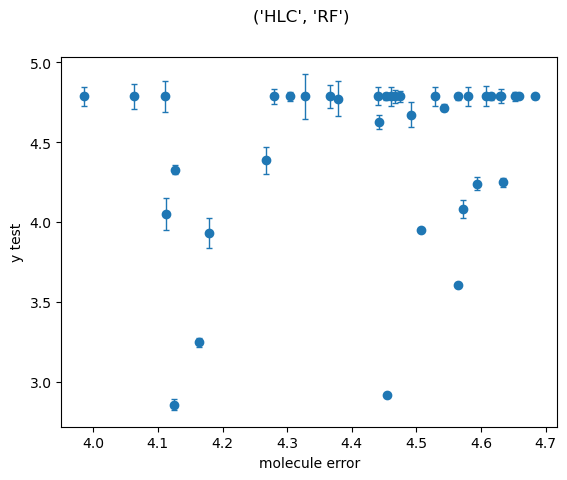

In [35]:
for isozyme in isozymes:
    model = best_models[isozyme]
    plt.clf()
    plt.errorbar(y_test_avg_predictions[isozyme][model], xy_splits[isozyme][3], yerr=stds[isozyme][model], linewidth=1, capsize=2, fmt='o')
    plt.xlabel('molecule error')
    plt.ylabel('y test')
    plt.suptitle(f"{isozyme, model}")
    plt.show()

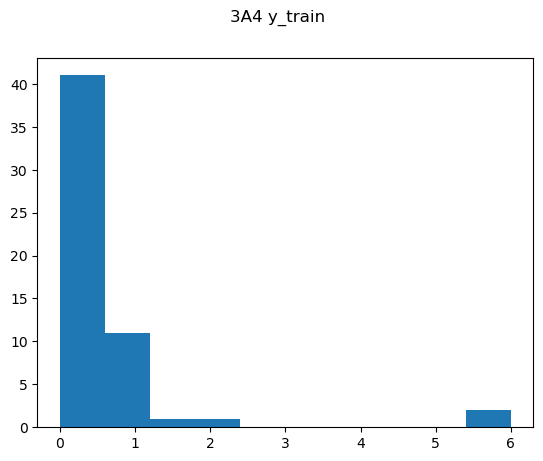

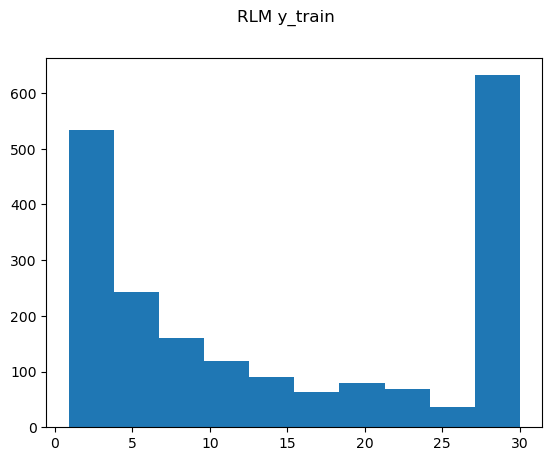

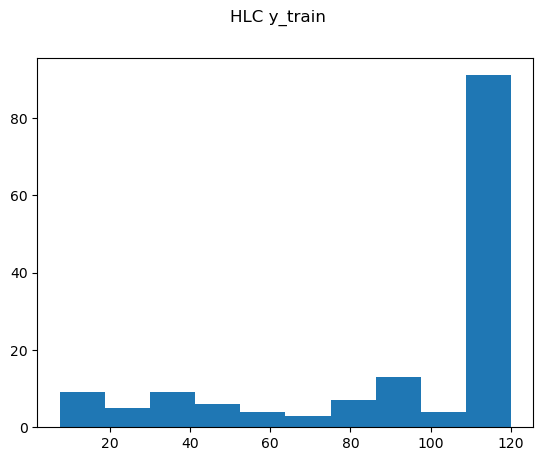

In [36]:
for isozyme in isozymes:
    y_train = np.exp(xy_splits[isozyme][2])
    plt.hist(y_train)
    plt.suptitle(f"{isozyme} y_train")
    plt.show()

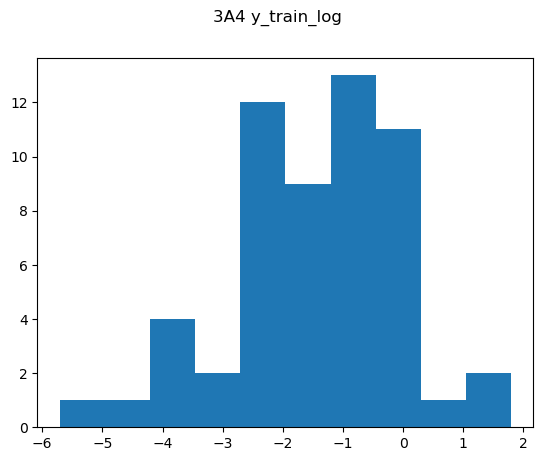

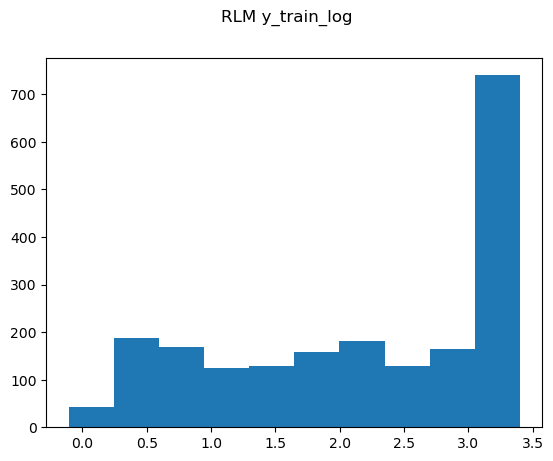

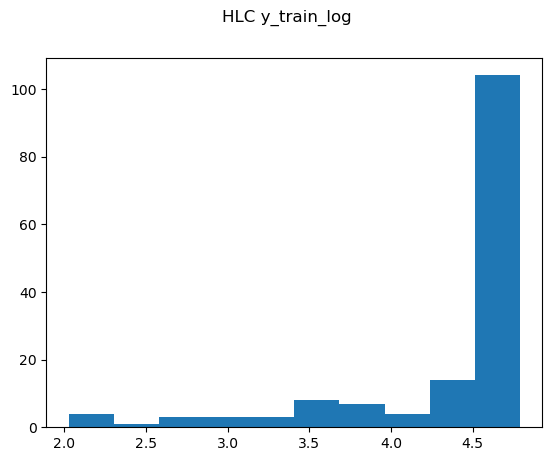

In [37]:
for isozyme in isozymes:
    y_train_log = xy_splits[isozyme][2]
    plt.hist(y_train_log)
    plt.suptitle(f"{isozyme} y_train_log")
    plt.show()